In [1]:
import torch
import numpy as np
import random
import os
random_seed = 2
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit/ruddit_with_text.csv")  # create a dateframe based on a file


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
df_.head()

,post_id,comment_id,txt,url,offensiveness_score
0,42g75o,cza1q49,"> The difference in average earnings between men and women can be explained by taking into account relevant factors.\n\nSo it isn't a myth, you just feel that you can explain it.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza1q49/,-0.083
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based on the sex of the person.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza1wdh/,-0.022
2,42g75o,cza23qx,[deleted],https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza23qx/,0.167
3,42g75o,cza2bw8,"The assertion is that women get paid less for the *same* jobs, and that they get paid less *because* they are women.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza2bw8/,-0.146
4,42g75o,cza2iji,"You said in the OP that's not what they're measuring. They're measuring aggregate. \n\nAs entertainers, women make less. Isn't that what JLaw was complaining about?",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza2iji/,-0.083


(5838, 5)


<AxesSubplot:>

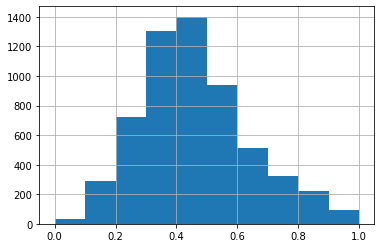

In [3]:
print(df_.shape) 
df_['y'] = df_['offensiveness_score']


min_data = df_.y.min()
max_data = df_.y.max()
df_['y'] = (df_['y']-min_data)/(max_data-min_data)
df_.y.hist()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import numpy as np
from nezha_pretraining import nezha_pretraining_store_id_data

def sequence_padding(inputs,maxlen,padding = 0):
    length = maxlen
    pad_width = [(0,0) for _ in np.shape(inputs[0])]
    #print('pad_width = ')
    #print(pad_width)
    outputs = []
    for x in inputs:
        x = x[:length]
        pad_width[0] = (0,length-len(x))
        x = np.pad(x,pad_width,'constant',constant_values=padding)
        outputs.append(x)
    return np.array(outputs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/模型/roberta-english-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
from torch.utils.data import Dataset,DataLoader
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")

In [7]:
Roberta,robertaconfig,get_data = get_model_function('roberta-base')
#_,robertaconfig,get_data = get_model_function('roberta-base')
config = robertaconfig(**json_data)
config.with_prediction = False
roberta = Roberta(config)

In [8]:
roberta = get_data(roberta,'/home/xiaoguzai/模型/unbiased-toxic-roberta/pytorch_model.bin')
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        #mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        #print('input_ids = ')
        #print(input_ids)
        output = self.model(input_ids)
        #print('output1 = ')
        #print(output)
        output = self.dropout(output)
        output = self.fc(output)
        #print('output2 = ')
        #print(output)
        return output
model = ClassificationModel(roberta,config,config.vocab_size)

Done loading 197 ROBERTA weights from: /home/xiaoguzai/模型/unbiased-toxic-roberta/pytorch_model.bin. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	roberta.embeddings.position_ids
	classifier.out_proj.weight
	classifier.dense.bias
	classifier.out_proj.bias
	classifier.dense.weight


In [9]:
current_data = model.state_dict()
current_data['fc.weight'] = current_data['model.robertaembeddings.word_embeddings_layer.weight']
current_data['fc.bias'] = torch.zeros_like(current_data['fc.bias'])
model.load_state_dict(current_data)
#!!!pytorch中的linear权重自动翻转

<All keys matched successfully>

## Mask掩码操作

In [10]:
text = df_['txt'].values.tolist()
label = df_['y'].values.tolist()

In [11]:
from p_tqdm import p_map
from functools import partial
#并发遮盖掩码
def nezha_pretraining_store_id_data(text_ids,label,begin,end):
    input_ids,labels = [],[]
    result_tuples = p_map(partial(random_mask,begin=begin,end=end),text_ids,label)
    def get_tuple0(input_ids):
        return input_ids[0]
    def get_tuple1(input_ids):
        return input_ids[1]
    input_ids = p_map(get_tuple0,result_tuples)
    labels = p_map(get_tuple1,result_tuples)
    return input_ids,labels

In [12]:
def random_mask(text_ids,label,begin,end):
    #对于只有id的脱敏数据进行ngram-mask
    input_ids, output_ids = [], []
    rands = np.random.random(len(text_ids))
    idx=0
    while idx<len(rands):
        if rands[idx]<0.15:#需要mask
            ngram=np.random.choice([1,2,3], p=[0.7,0.2,0.1])#若要mask，进行x_gram mask的概率
            if ngram==3 and len(rands)<7:#太大的gram不要应用于过短文本
                ngram=2
            if ngram==2 and len(rands)<4:
                ngram=1
            L=idx+1
            R=idx+ngram#最终需要mask的右边界（开）
            while L<R and L<len(rands):
                rands[L]=np.random.random()*0.15#强制mask
                L+=1
            idx=R
            if idx<len(rands):
                rands[idx]=1#禁止mask片段的下一个token被mask，防止一大片连续mask
        idx+=1

    sep_id = tokenizer.convert_tokens_to_ids(["</s>"])
    sep_id = sep_id[0]
    cls_id = tokenizer.convert_tokens_to_ids(["<s>"])
    cls_id = cls_id[0]
    mask_id = tokenizer.convert_tokens_to_ids(["<mask>"])
    mask_id = mask_id[0]
    #cls_id = 0,sep_id = 2,mask_id = ...
    for index in range(len(text_ids)):
        r = rands[index]
        i = text_ids[index]
        if text_ids[index] in [sep_id,cls_id,mask_id] or index == len(text_ids)-1:
            input_ids.append(i)
            output_ids.append(-100)
            #保持原样不预测
            continue
        if r < 0.15 * 0.8:
            input_ids.append(mask_id)
            output_ids.append(i)#mask预测自己
        elif r < 0.15 * 0.9:
            input_ids.append(i)
            output_ids.append(i)#自己预测自己
        elif r < 0.15:
            input_ids.append(np.random.randint(begin,end))
            output_ids.append(i)#随机的一个词预测自己，随机词不会从特殊符号中选取，有小概率抽到自己
        else:
            input_ids.append(i)
            output_ids.append(-100)#保持原样不预测
    
    prelabel = 'The point is'
    pre_id = tokenizer(prelabel)['input_ids'][1:-1]
    label = str(label)
    label_id = tokenizer(label)['input_ids'][1:-1]+[sep_id]
    rands = np.random.rand()
    
    input_label_id = pre_id
    output_label_id = [-100]*len(pre_id)
    
    for index in range(len(label_id)):
        i = label_id[index]
        if i in [sep_id,cls_id,mask_id] or index == len(text_ids)-1:
            input_label_id.append(i)
            output_label_id.append(-100)
            #保持原样不预测
            continue
        if rands < 0.15 * 0.8:
            input_label_id.append(mask_id)
            output_label_id.append(i)#mask预测自己
        elif r < 0.15 * 0.9:
            input_label_id.append(i)
            output_label_id.append(i)#自己预测自己
        elif r < 0.15:
            input_label_id.append(np.random.randint(begin,end))
            output_label_id.append(i)#随机的一个词预测自己，随机词不会从特殊符号中选取，有小概率抽到自己
        else:
            input_label_id.append(i)
            output_label_id.append(-100)#保持原样不预测
    
    input_ids = input_ids+input_label_id
    output_ids = output_ids+output_label_id
    
    return input_ids, output_ids

In [13]:
text_ids = [1,2,3,4,5]
result_ids,result_output_ids = random_mask(text_ids,0.133,0,config.vocab_size)

In [14]:
result_ids

[1, 2, 3, 4, 5, 133, 477, 16, 288, 4, 25037, 2]

In [15]:
result_output_ids

[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]

In [16]:
text_ids = []
for index in range(len(text)):
    current_text = text[index]
    current_id = tokenizer(current_text)['input_ids']
    text_ids.append(current_id)
    
pretrain_id,pretrain_label = nezha_pretraining_store_id_data(text_ids,label,0,config.vocab_size)

  0%|          | 0/5838 [00:00<?, ?it/s]

  0%|          | 0/5838 [00:00<?, ?it/s]

  0%|          | 0/5838 [00:00<?, ?it/s]

In [17]:
model

ClassificationModel(
  (model): Roberta(
    (robertaembeddings): Embeddings(
      (word_embeddings_layer): Embedding(50265, 768)
      (segment_embeddings_layer): Embedding(1, 768)
      (position_embeddings_layer): Embedding(514, 768)
      (layer_normalization): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout_layer): Dropout(p=0.1, inplace=False)
    )
    (roberta_encoder_layer): ModuleList(
      (0): Transformer(
        (attention): AttentionLayer(
          (query_layer): Linear(in_features=768, out_features=768, bias=True)
          (key_layer): Linear(in_features=768, out_features=768, bias=True)
          (value_layer): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dense0): Linear(in_features=768, out_features=768, bias=True)
        (dropout0): Dropout(p=0.1, inplace=False)
        (layer_norm0): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dense): Linear(in_

In [18]:
pretrain_id[0:5]

[[0,
  15698,
  20,
  2249,
  11,
  674,
  50264,
  227,
  604,
  8,
  390,
  64,
  50264,
  50264,
  50264,
  602,
  50264,
  1316,
  4249,
  2433,
  50264,
  50264,
  50118,
  2847,
  24,
  965,
  75,
  10,
  17721,
  6,
  47,
  95,
  619,
  14,
  47,
  64,
  3922,
  24,
  4,
  2,
  133,
  477,
  16,
  50264,
  50264,
  50264,
  50264,
  50264,
  50264,
  50264,
  50264,
  50264,
  2],
 [0,
  133,
  17721,
  16,
  14,
  5,
  22,
  29183,
  113,
  16,
  4378,
  716,
  50264,
  5,
  50264,
  9,
  50264,
  1437,
  621,
  4,
  50264,
  2,
  133,
  477,
  16,
  288,
  4,
  38888,
  1558,
  31782,
  1922,
  24108,
  3103,
  6232,
  2],
 [0,
  10975,
  2794,
  36140,
  742,
  2,
  133,
  477,
  16,
  288,
  4,
  37402,
  23417,
  3414,
  5714,
  37020,
  3079,
  2],
 [0,
  133,
  19395,
  16,
  14,
  390,
  120,
  1199,
  540,
  13,
  5,
  1009,
  50264,
  23432,
  1315,
  6,
  50264,
  14,
  51,
  120,
  50264,
  50264,
  1009,
  13437,
  3226,
  51,
  32,
  390,
  4,
  1437,
  2,
  133,
 

In [19]:
pretrain_label[0:5]

[[-100,
  -100,
  -100,
  -100,
  -100,
  674,
  1107,
  -100,
  -100,
  -100,
  -100,
  -100,
  28,
  2002,
  30,
  -100,
  88,
  -100,
  -100,
  -100,
  4,
  50118,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  288,
  4,
  3897,
  26629,
  2545,
  1549,
  2546,
  2831,
  39190,
  -100],
 [-100,
  -100,
  -100,
  -100,
  -100,
  5,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  15,
  -100,
  2099,
  -100,
  5,
  -100,
  -100,
  -100,
  1437,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100],
 [-100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  288,
  4,
  37402,
  23417,
  3414,
  -100,
  37020,
  3079,
  -100],
 [-100,
  -100,
  -100,
  -100,
  -100,
  390,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  41690,
  3226,
  -100,
  -100,
  8,
  -100,
  -100,
  -100,
  1199,
  54

In [20]:
class ClassificationDataset(Dataset):
    def __init__(self,pretrain_id,pretrain_label,maxlen):
        result_id,result_label = [],[]
        self.pretrain_id = pretrain_id
        self.maxlen = maxlen
        for index in tqdm(range(len(pretrain_id))):
            current_id = pretrain_id[index]
            current_id = self.sequence_padding(current_id,padding=1)
            result_id.append(current_id)
            current_label = pretrain_label[index]
            current_label = self.sequence_padding(current_label,padding=-100)
            #!!!注意两个padding不一样，输入的current_id的padding只能为1
            result_label.append(current_label)
        self.tensors = [torch.tensor(result_id),torch.tensor(result_label)]
        
    def __len__(self):
        return len(self.pretrain_id)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = -100):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x

In [21]:
print(device)

cuda:0


In [22]:
model

ClassificationModel(
  (model): Roberta(
    (robertaembeddings): Embeddings(
      (word_embeddings_layer): Embedding(50265, 768)
      (segment_embeddings_layer): Embedding(1, 768)
      (position_embeddings_layer): Embedding(514, 768)
      (layer_normalization): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout_layer): Dropout(p=0.1, inplace=False)
    )
    (roberta_encoder_layer): ModuleList(
      (0): Transformer(
        (attention): AttentionLayer(
          (query_layer): Linear(in_features=768, out_features=768, bias=True)
          (key_layer): Linear(in_features=768, out_features=768, bias=True)
          (value_layer): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dense0): Linear(in_features=768, out_features=768, bias=True)
        (dropout0): Dropout(p=0.1, inplace=False)
        (layer_norm0): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dense): Linear(in_

In [23]:
optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
loss_func = torch.nn.CrossEntropyLoss()
#torch.cuda.set_device(0)
#torch.cuda.set_device(0)
model = model.to(device)
model = nn.DataParallel(model)
model.train()
#scaler = torch.cuda.amp.GradScaler()
best_loss = 999999999999
best_accuracy = 0.0
content_dataset = ClassificationDataset(pretrain_id,pretrain_label,maxlen=500)
content_data_iter = DataLoader(content_dataset,batch_size=4,shuffle=True)
for epoch in range(401):
    print('epoch {}'.format(epoch+1))
    train_loss = 0
    train_acc = 0
    content_dataset_len = len(content_data_iter)
    for batch_token_ids,batch_labels in tqdm(content_data_iter,colour='blue'):
        batch_token_ids = batch_token_ids.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        output = model(batch_token_ids)
        output = output.view(-1,config.vocab_size)
        batch_labels = batch_labels.view(-1)
        loss = loss_func(output,batch_labels)
        train_loss += loss
        pred = torch.max(output, 1)[1]
        train_correct = (pred == batch_labels).sum()
        train_acc += train_correct
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        loss.backward()
        optimizer.step()
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss/content_dataset_len, train_acc/content_dataset_len))
    current_loss = train_loss/content_dataset_len
    current_accuracy = train_acc/content_dataset_len
    if current_loss < best_loss and current_accuracy > best_accuracy:
        torch.save(model.state_dict(),'/home/xiaoguzai/模型/toxic-comment预训练结果/'+'labeled_data+best_data.pth')
    if epoch%10 == 0:
        torch.save(model.state_dict(),'/home/xiaoguzai/模型/toxic-comment预训练结果/'+'labeled_data+model_epoch='+str(epoch)+'.pth')



100%|████████████████████████████████████| 5838/5838 [00:00<00:00, 32236.18it/s]


epoch 1


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 6.599020, Acc: 6.560274
epoch 2


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 5.252014, Acc: 9.835617
epoch 3


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 4.827861, Acc: 11.227398
epoch 4


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.00it/s]


Train Loss: 4.537796, Acc: 12.184932
epoch 5


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.00it/s]


Train Loss: 4.287529, Acc: 13.132877
epoch 6


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.00it/s]


Train Loss: 4.070636, Acc: 13.984247
epoch 7


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 3.891366, Acc: 14.737672
epoch 8


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 3.699576, Acc: 15.634932
epoch 9


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.00it/s]


Train Loss: 3.524062, Acc: 16.434246
epoch 10


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 3.349099, Acc: 17.335617
epoch 11


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 3.193014, Acc: 18.249315
epoch 12


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 3.033239, Acc: 19.184248
epoch 13


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 2.876667, Acc: 19.995207
epoch 14


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 2.739540, Acc: 20.869864
epoch 15


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 2.589706, Acc: 21.799316
epoch 16


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.98it/s]


Train Loss: 2.467078, Acc: 22.656164
epoch 17


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 2.345492, Acc: 23.434248
epoch 18


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.98it/s]


Train Loss: 2.227724, Acc: 24.366440
epoch 19


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 2.111485, Acc: 25.086302
epoch 20


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.98it/s]


Train Loss: 2.001341, Acc: 26.016439
epoch 21


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.98it/s]


Train Loss: 1.899545, Acc: 26.756849
epoch 22


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.98it/s]


Train Loss: 1.806276, Acc: 27.452740
epoch 23


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 1.706626, Acc: 28.192467
epoch 24


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 1.618659, Acc: 28.802740
epoch 25


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 1.546611, Acc: 29.490412
epoch 26


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.98it/s]


Train Loss: 1.464567, Acc: 30.071918
epoch 27


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.99it/s]


Train Loss: 1.400934, Acc: 30.607534
epoch 28


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 1.320650, Acc: 31.221233
epoch 29


100%|███████████████████████████████████████| 1460/1460 [03:06<00:00,  7.82it/s]


Train Loss: 1.264946, Acc: 31.641096
epoch 30


100%|███████████████████████████████████████| 1460/1460 [03:07<00:00,  7.78it/s]


Train Loss: 1.211173, Acc: 32.144520
epoch 31


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 1.153340, Acc: 32.584934
epoch 32


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.00it/s]


Train Loss: 1.082113, Acc: 33.042465
epoch 33


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 1.027908, Acc: 33.469177
epoch 34


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.991512, Acc: 33.799316
epoch 35


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.935776, Acc: 34.279453
epoch 36


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.879963, Acc: 34.594521
epoch 37


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.845627, Acc: 34.994522
epoch 38


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.799918, Acc: 35.364384
epoch 39


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.751396, Acc: 35.641098
epoch 40


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.703066, Acc: 36.121235
epoch 41


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.669545, Acc: 36.303425
epoch 42


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.619824, Acc: 36.696575
epoch 43


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.583116, Acc: 36.979454
epoch 44


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.543664, Acc: 37.250687
epoch 45


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.509506, Acc: 37.551373
epoch 46


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.478248, Acc: 37.838356
epoch 47


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.439294, Acc: 38.200001
epoch 48


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.410272, Acc: 38.448631
epoch 49


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.379945, Acc: 38.669178
epoch 50


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.348331, Acc: 38.888359
epoch 51


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.324578, Acc: 39.123287
epoch 52


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.301066, Acc: 39.306164
epoch 53


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.275281, Acc: 39.491096
epoch 54


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.258876, Acc: 39.682194
epoch 55


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.232250, Acc: 39.837673
epoch 56


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.215291, Acc: 39.994522
epoch 57


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.199663, Acc: 40.100002
epoch 58


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.187102, Acc: 40.154110
epoch 59


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.173451, Acc: 40.298630
epoch 60


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.161203, Acc: 40.413013
epoch 61


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.151720, Acc: 40.454109
epoch 62


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.142663, Acc: 40.517124
epoch 63


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.131531, Acc: 40.543152
epoch 64


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.118875, Acc: 40.633564
epoch 65


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.110003, Acc: 40.658905
epoch 66


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.105403, Acc: 40.692467
epoch 67


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.098310, Acc: 40.735619
epoch 68


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.088916, Acc: 40.815071
epoch 69


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.082451, Acc: 40.826714
epoch 70


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.080564, Acc: 40.813015
epoch 71


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.070251, Acc: 40.873974
epoch 72


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.064932, Acc: 40.888359
epoch 73


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.059639, Acc: 40.898632
epoch 74


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.055667, Acc: 40.899315
epoch 75


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.052096, Acc: 40.915756
epoch 76


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.053093, Acc: 40.895206
epoch 77


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.046014, Acc: 40.935619
epoch 78


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.043737, Acc: 40.923290
epoch 79


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.043411, Acc: 40.904797
epoch 80


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.037936, Acc: 40.943153
epoch 81


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.038063, Acc: 40.921234
epoch 82


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.036775, Acc: 40.916439
epoch 83


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.034275, Acc: 40.939041
epoch 84


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.032313, Acc: 40.930824
epoch 85


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.027457, Acc: 40.968494
epoch 86


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.027308, Acc: 40.947262
epoch 87


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.029333, Acc: 40.931507
epoch 88


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.025654, Acc: 40.941780
epoch 89


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.021999, Acc: 40.969181
epoch 90


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.024989, Acc: 40.945892
epoch 91


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.021006, Acc: 40.963699
epoch 92


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.020782, Acc: 40.973972
epoch 93


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.022650, Acc: 40.940411
epoch 94


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.019173, Acc: 40.965755
epoch 95


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.018578, Acc: 40.969864
epoch 96


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.017308, Acc: 40.974659
epoch 97


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.016700, Acc: 40.992466
epoch 98


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.017659, Acc: 40.962330
epoch 99


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.019480, Acc: 40.952740
epoch 100


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.015610, Acc: 40.971920
epoch 101


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.013717, Acc: 40.993153
epoch 102


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.016470, Acc: 40.965069
epoch 103


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.014035, Acc: 40.984932
epoch 104


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.04it/s]


Train Loss: 0.015349, Acc: 40.964386
epoch 105


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.016424, Acc: 40.954796
epoch 106


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.014573, Acc: 40.978085
epoch 107


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.013000, Acc: 40.978085
epoch 108


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.03it/s]


Train Loss: 0.012166, Acc: 40.978085
epoch 109


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.02it/s]


Train Loss: 0.013530, Acc: 40.967125
epoch 110


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.011571, Acc: 40.989727
epoch 111


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.011456, Acc: 40.985619
epoch 112


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.01it/s]


Train Loss: 0.014040, Acc: 40.969181
epoch 113


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.012514, Acc: 40.979454
epoch 114


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.013325, Acc: 40.974659
epoch 115


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.009604, Acc: 40.989040
epoch 116


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.010047, Acc: 40.997948
epoch 117


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.013445, Acc: 40.956165
epoch 118


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.011814, Acc: 40.976028
epoch 119


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.010622, Acc: 40.993153
epoch 120


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.009292, Acc: 41.003426
epoch 121


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.008928, Acc: 41.005482
epoch 122


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.012398, Acc: 40.978085
epoch 123


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.008578, Acc: 41.008221
epoch 124


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.007867, Acc: 40.999317
epoch 125


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.010611, Acc: 40.989040
epoch 126


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.009781, Acc: 40.990414
epoch 127


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.010410, Acc: 40.989727
epoch 128


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.94it/s]


Train Loss: 0.008311, Acc: 41.004112
epoch 129


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.009252, Acc: 40.986988
epoch 130


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.010510, Acc: 40.990414
epoch 131


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.010084, Acc: 40.991096
epoch 132


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.008356, Acc: 41.011646
epoch 133


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.009005, Acc: 40.993835
epoch 134


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006875, Acc: 41.010960
epoch 135


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007716, Acc: 40.996578
epoch 136


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.009536, Acc: 40.990414
epoch 137


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006397, Acc: 41.013699
epoch 138


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006453, Acc: 41.013016
epoch 139


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006407, Acc: 41.007534
epoch 140


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.008969, Acc: 41.007534
epoch 141


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007295, Acc: 41.019180
epoch 142


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007100, Acc: 41.009590
epoch 143


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007975, Acc: 40.997948
epoch 144


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007701, Acc: 41.003426
epoch 145


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.009585, Acc: 40.988358
epoch 146


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007544, Acc: 40.992466
epoch 147


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007577, Acc: 41.001369
epoch 148


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.008086, Acc: 41.000000
epoch 149


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.008186, Acc: 40.989727
epoch 150


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005968, Acc: 41.017811
epoch 151


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007734, Acc: 40.996578
epoch 152


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007346, Acc: 40.992466
epoch 153


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007929, Acc: 41.004112
epoch 154


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.009084, Acc: 40.980137
epoch 155


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.008608, Acc: 40.983562
epoch 156


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006369, Acc: 41.017811
epoch 157


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005877, Acc: 41.010960
epoch 158


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003975, Acc: 41.027397
epoch 159


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006882, Acc: 41.002056
epoch 160


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005205, Acc: 41.023975
epoch 161


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.008020, Acc: 40.997261
epoch 162


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007340, Acc: 40.992466
epoch 163


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007471, Acc: 41.002056
epoch 164


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004465, Acc: 41.015068
epoch 165


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004320, Acc: 41.030140
epoch 166


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005209, Acc: 41.004795
epoch 167


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006960, Acc: 41.013699
epoch 168


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.004907, Acc: 41.017811
epoch 169


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004777, Acc: 41.016441
epoch 170


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004820, Acc: 41.019863
epoch 171


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007014, Acc: 41.005482
epoch 172


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004818, Acc: 41.023975
epoch 173


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006640, Acc: 41.012329
epoch 174


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006297, Acc: 41.000687
epoch 175


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004990, Acc: 41.021919
epoch 176


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006001, Acc: 41.014385
epoch 177


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006732, Acc: 40.997948
epoch 178


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005079, Acc: 41.018494
epoch 179


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003120, Acc: 41.029453
epoch 180


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.009294, Acc: 40.984932
epoch 181


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005829, Acc: 41.016441
epoch 182


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005765, Acc: 41.015755
epoch 183


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006045, Acc: 41.003426
epoch 184


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007122, Acc: 41.003426
epoch 185


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.004689, Acc: 41.018494
epoch 186


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003894, Acc: 41.031509
epoch 187


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.006418, Acc: 41.004112
epoch 188


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005687, Acc: 41.013016
epoch 189


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005365, Acc: 41.021233
epoch 190


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002903, Acc: 41.039043
epoch 191


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002489, Acc: 41.040413
epoch 192


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004975, Acc: 41.020550
epoch 193


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005357, Acc: 41.013016
epoch 194


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004890, Acc: 41.013016
epoch 195


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005484, Acc: 41.014385
epoch 196


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005715, Acc: 41.009590
epoch 197


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003519, Acc: 41.033562
epoch 198


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004928, Acc: 41.017811
epoch 199


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006694, Acc: 41.012329
epoch 200


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004427, Acc: 41.027397
epoch 201


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004243, Acc: 41.023289
epoch 202


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004785, Acc: 41.021233
epoch 203


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005485, Acc: 41.021233
epoch 204


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005110, Acc: 41.013699
epoch 205


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004674, Acc: 41.024658
epoch 206


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003668, Acc: 41.025345
epoch 207


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004987, Acc: 41.018494
epoch 208


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003366, Acc: 41.036301
epoch 209


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003882, Acc: 41.021233
epoch 210


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002429, Acc: 41.036301
epoch 211


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002742, Acc: 41.034931
epoch 212


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004365, Acc: 41.019863
epoch 213


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004632, Acc: 41.019863
epoch 214


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003905, Acc: 41.032192
epoch 215


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.008143, Acc: 41.011646
epoch 216


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004432, Acc: 41.019863
epoch 217


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003679, Acc: 41.028084
epoch 218


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005531, Acc: 41.019863
epoch 219


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003503, Acc: 41.027397
epoch 220


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002711, Acc: 41.038357
epoch 221


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002989, Acc: 41.028767
epoch 222


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.005059, Acc: 41.028767
epoch 223


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004695, Acc: 41.022602
epoch 224


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003562, Acc: 41.030823
epoch 225


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003321, Acc: 41.032192
epoch 226


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006053, Acc: 41.021233
epoch 227


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004121, Acc: 41.026714
epoch 228


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002890, Acc: 41.040413
epoch 229


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004672, Acc: 41.021919
epoch 230


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004716, Acc: 41.020550
epoch 231


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004423, Acc: 41.017124
epoch 232


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004355, Acc: 41.023289
epoch 233


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004049, Acc: 41.020550
epoch 234


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003939, Acc: 41.023975
epoch 235


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003424, Acc: 41.030140
epoch 236


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004471, Acc: 41.019180
epoch 237


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004769, Acc: 41.023289
epoch 238


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002902, Acc: 41.036301
epoch 239


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003140, Acc: 41.032192
epoch 240


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003260, Acc: 41.029453
epoch 241


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004616, Acc: 41.029453
epoch 242


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004535, Acc: 41.027397
epoch 243


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003395, Acc: 41.032879
epoch 244


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002320, Acc: 41.039726
epoch 245


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003179, Acc: 41.031509
epoch 246


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003243, Acc: 41.033562
epoch 247


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004006, Acc: 41.030823
epoch 248


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004254, Acc: 41.016441
epoch 249


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004541, Acc: 41.032879
epoch 250


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005607, Acc: 41.012329
epoch 251


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003437, Acc: 41.028084
epoch 252


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.001934, Acc: 41.043152
epoch 253


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002724, Acc: 41.037674
epoch 254


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003807, Acc: 41.022602
epoch 255


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003826, Acc: 41.030140
epoch 256


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003486, Acc: 41.028767
epoch 257


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003353, Acc: 41.023975
epoch 258


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002964, Acc: 41.033562
epoch 259


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002765, Acc: 41.032879
epoch 260


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003561, Acc: 41.032192
epoch 261


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004752, Acc: 41.019180
epoch 262


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002406, Acc: 41.039726
epoch 263


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002838, Acc: 41.038357
epoch 264


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.005280, Acc: 41.004795
epoch 265


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003700, Acc: 41.028767
epoch 266


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003194, Acc: 41.028084
epoch 267


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003596, Acc: 41.024658
epoch 268


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004509, Acc: 41.025345
epoch 269


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004651, Acc: 41.022602
epoch 270


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.001855, Acc: 41.047260
epoch 271


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.001778, Acc: 41.045208
epoch 272


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002046, Acc: 41.048630
epoch 273


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002996, Acc: 41.033562
epoch 274


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.004498, Acc: 41.015068
epoch 275


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002704, Acc: 41.036987
epoch 276


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002301, Acc: 41.040413
epoch 277


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002414, Acc: 41.032879
epoch 278


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002962, Acc: 41.026028
epoch 279


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003783, Acc: 41.026714
epoch 280


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.003640, Acc: 41.027397
epoch 281


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002432, Acc: 41.038357
epoch 282


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.006948, Acc: 40.997261
epoch 283


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002772, Acc: 41.034931
epoch 284


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.001496, Acc: 41.047260
epoch 285


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.001865, Acc: 41.038357
epoch 286


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.007338, Acc: 41.008221
epoch 287


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.003073, Acc: 41.038357
epoch 288


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002467, Acc: 41.040413
epoch 289


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.95it/s]


Train Loss: 0.002481, Acc: 41.042465
epoch 290


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.003028, Acc: 41.026028
epoch 291


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.003803, Acc: 41.039726
epoch 292


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.001379, Acc: 41.049316
epoch 293


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.96it/s]


Train Loss: 0.003169, Acc: 41.025345
epoch 294


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.98it/s]


Train Loss: 0.002424, Acc: 41.041096
epoch 295


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.98it/s]


Train Loss: 0.003935, Acc: 41.023975
epoch 296


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.98it/s]


Train Loss: 0.004143, Acc: 41.025345
epoch 297


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.97it/s]


Train Loss: 0.003053, Acc: 41.030140
epoch 298


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.98it/s]


Train Loss: 0.002059, Acc: 41.043152
epoch 299


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.98it/s]


Train Loss: 0.001664, Acc: 41.039726
epoch 300


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.98it/s]


Train Loss: 0.006400, Acc: 41.017811
epoch 301


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.97it/s]


Train Loss: 0.002105, Acc: 41.039726
epoch 302


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.98it/s]


Train Loss: 0.001929, Acc: 41.041096
epoch 303


100%|███████████████████████████████████████| 1460/1460 [03:03<00:00,  7.98it/s]


Train Loss: 0.002955, Acc: 41.033562
epoch 304


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  7.98it/s]


Train Loss: 0.003399, Acc: 41.034931
epoch 305


100%|███████████████████████████████████████| 1460/1460 [03:02<00:00,  8.02it/s]


Train Loss: 0.002386, Acc: 41.049999
epoch 306


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002759, Acc: 41.040413
epoch 307


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002305, Acc: 41.045891
epoch 308


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002047, Acc: 41.039726
epoch 309


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.003369, Acc: 41.026028
epoch 310


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002670, Acc: 41.038357
epoch 311


100%|███████████████████████████████████████| 1460/1460 [03:00<00:00,  8.07it/s]


Train Loss: 0.002114, Acc: 41.037674
epoch 312


100%|███████████████████████████████████████| 1460/1460 [03:00<00:00,  8.07it/s]


Train Loss: 0.002912, Acc: 41.036987
epoch 313


100%|███████████████████████████████████████| 1460/1460 [03:00<00:00,  8.07it/s]


Train Loss: 0.002146, Acc: 41.041096
epoch 314


100%|███████████████████████████████████████| 1460/1460 [03:00<00:00,  8.07it/s]


Train Loss: 0.003814, Acc: 41.019180
epoch 315


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.005569, Acc: 41.025345
epoch 316


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.003243, Acc: 41.032192
epoch 317


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.003744, Acc: 41.026714
epoch 318


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.001974, Acc: 41.043152
epoch 319


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002497, Acc: 41.035618
epoch 320


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002549, Acc: 41.036987
epoch 321


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.003845, Acc: 41.026028
epoch 322


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002055, Acc: 41.045208
epoch 323


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.001581, Acc: 41.047947
epoch 324


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002969, Acc: 41.035618
epoch 325


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002901, Acc: 41.030823
epoch 326


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.001277, Acc: 41.048630
epoch 327


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002947, Acc: 41.039043
epoch 328


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.005777, Acc: 41.015755
epoch 329


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002020, Acc: 41.036987
epoch 330


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.001585, Acc: 41.041782
epoch 331


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002569, Acc: 41.029453
epoch 332


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.003508, Acc: 41.027397
epoch 333


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002598, Acc: 41.034248
epoch 334


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002650, Acc: 41.039043
epoch 335


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002853, Acc: 41.034931
epoch 336


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.003695, Acc: 41.021919
epoch 337


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002254, Acc: 41.037674
epoch 338


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.006287, Acc: 41.010960
epoch 339


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002340, Acc: 41.034931
epoch 340


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003017, Acc: 41.030823
epoch 341


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001924, Acc: 41.042465
epoch 342


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003367, Acc: 41.030140
epoch 343


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001542, Acc: 41.050686
epoch 344


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002130, Acc: 41.038357
epoch 345


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001446, Acc: 41.043839
epoch 346


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002733, Acc: 41.031509
epoch 347


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002577, Acc: 41.034248
epoch 348


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001897, Acc: 41.047947
epoch 349


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002879, Acc: 41.036987
epoch 350


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.000615, Acc: 41.054794
epoch 351


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002970, Acc: 41.027397
epoch 352


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003329, Acc: 41.036301
epoch 353


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003355, Acc: 41.030140
epoch 354


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002975, Acc: 41.039043
epoch 355


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003087, Acc: 41.033562
epoch 356


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002898, Acc: 41.034248
epoch 357


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002730, Acc: 41.035618
epoch 358


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002792, Acc: 41.034931
epoch 359


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002157, Acc: 41.041782
epoch 360


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002469, Acc: 41.039043
epoch 361


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002426, Acc: 41.038357
epoch 362


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003829, Acc: 41.025345
epoch 363


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002151, Acc: 41.042465
epoch 364


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002792, Acc: 41.030823
epoch 365


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002731, Acc: 41.034248
epoch 366


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002154, Acc: 41.041782
epoch 367


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002902, Acc: 41.032879
epoch 368


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003120, Acc: 41.026028
epoch 369


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001998, Acc: 41.041096
epoch 370


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003659, Acc: 41.027397
epoch 371


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003059, Acc: 41.041096
epoch 372


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001072, Acc: 41.045891
epoch 373


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.000884, Acc: 41.050686
epoch 374


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.004549, Acc: 41.012329
epoch 375


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002552, Acc: 41.035618
epoch 376


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002412, Acc: 41.037674
epoch 377


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002062, Acc: 41.039726
epoch 378


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002219, Acc: 41.041782
epoch 379


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002324, Acc: 41.034248
epoch 380


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002559, Acc: 41.036301
epoch 381


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002590, Acc: 41.042465
epoch 382


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001660, Acc: 41.041782
epoch 383


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001143, Acc: 41.049316
epoch 384


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.002884, Acc: 41.028767
epoch 385


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.001564, Acc: 41.041782
epoch 386


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.003482, Acc: 41.025345
epoch 387


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.001607, Acc: 41.048630
epoch 388


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001661, Acc: 41.044521
epoch 389


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003125, Acc: 41.031509
epoch 390


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.003628, Acc: 41.033562
epoch 391


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001952, Acc: 41.045891
epoch 392


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001466, Acc: 41.040413
epoch 393


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002773, Acc: 41.034248
epoch 394


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002662, Acc: 41.041096
epoch 395


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.001912, Acc: 41.036301
epoch 396


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.06it/s]


Train Loss: 0.003215, Acc: 41.036301
epoch 397


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001665, Acc: 41.049999
epoch 398


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001779, Acc: 41.047260
epoch 399


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.002201, Acc: 41.043152
epoch 400


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001311, Acc: 41.047260
epoch 401


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.001508, Acc: 41.043839
